<a href="https://colab.research.google.com/github/atheermoh/bee-flightpath-reconstruction/blob/main/bee_flight_path.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Datafiles

In [2]:
import urllib.request
import numpy as np
import matplotlib.pyplot as plt

urllib.request.urlretrieve('https://drive.usercontent.google.com/download?id=1XrXVkEfFtgA9VlU2rP4-gGdI_7-TmJ4k&export=download&authuser=0','bee_flightpaths.npy')
dataset = np.load('bee_flightpaths.npy',allow_pickle=True)

Nbases = 10 #number of bases per axis

## Reconstructing a Bee’s Flight Path from Directional Sensor Observations

This project explores the problem of estimating the 2D flight path of a bumblebee from partial, noisy directional observations recorded by fixed detectors in an environment. The tracking system consists of four detectors positioned at known coordinates. Each detector occasionally records the **bearing** (direction) of the bee at different time points, without providing distance information.

In the visual example below, the detectors are shown as green circles and the true trajectory of the bee as a continuous red curve. Blue lines indicate the directional bearings measured at selected timestamps.

<img src="https://drive.usercontent.google.com/download?id=1IIaTWlqDuUla6tmL2usinWcOs_aJknb7&export=download&authuser=0&confirm=t&uuid=ee31fadf-4593-468f-b759-6a418767006c&at=AENtkXYQ8DcCgp1c8l__xmzCyWQp:1730720770038" />

*Flight path of a bee with bearings recorded by each detector at multiple times. Detectors provide only direction, not distance, to the bee.*

The dataset contains **30 flight paths**, each structured as a dictionary with two components:

### **• `truepath`**
A `(100 × 3)` array containing:
- time `t`
- x-coordinate  
- y-coordinate  

For example:



```
 array([[  0.  , -43.11,  11.27],
       [  0.3 , -43.68,   9.49],
       [  0.61, -44.03,   7.69],
       [  0.91, -44.15,   5.88],
       [  1.21, -44.03,   4.07],
            :      :        :
```

A `(17 × 5)` array where each row records:
- time  
- detector x position  
- detector y position  
- observed bearing unit-vector (bx, by)

Example:

```
array([[  0.  , -15.  , -15.  ,  -0.73,   0.68],
       [  0.91,  15.  ,  15.  ,  -0.99,  -0.15],
       [  1.82, -15.  ,  15.  ,  -0.89,  -0.46],
       [  2.73,  15.  , -15.  ,  -0.98,   0.18],
       [  3.64, -15.  ,  15.  ,  -0.62,  -0.78],
       [  4.55,  15.  , -15.  ,  -1.  ,   0.02],
       [  5.45, -15.  , -15.  ,  -0.89,  -0.45],
           :     :       :         :       :
```



These observations supply directional information only; the core challenge is reconstructing the bee’s trajectory from this limited signal.

---

## Visualising the True Flight Path

The code below visualises the ground-truth trajectory for one of the bees (`dataset[1]`) and highlights the starting position at `t = 0`.


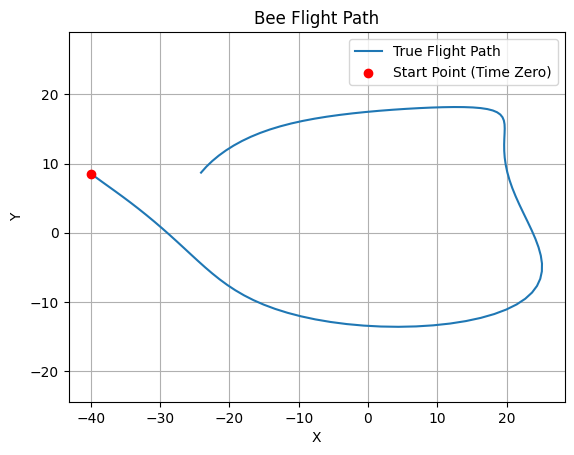

In [3]:
import numpy as np
import matplotlib.pyplot as plt

dataset = np.load('bee_flightpaths.npy', allow_pickle=True)

# Extract the true flight path
truepath = dataset[1]['truepath']

plt.plot(truepath[:, 1], truepath[:, 2], label='True Flight Path')

# Mark the starting point at time zero
plt.scatter(truepath[0, 1], truepath[0, 2], color='red',
            label='Start Point (Time Zero)', zorder=5)

plt.title('Bee Flight Path')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid()
plt.axis('equal')
plt.show()

The x- and y-coordinates extracted from truepath represent the bee’s position at successive timestamps.

Understanding Observation Likelihood
To evaluate how well a predicted location matches an actual detector observation, we compute the negative log-likelihood of the observation given a proposed bee position.
Given:
a predicted position p = [px, py]
an observation row:
obs = [t, detector_x, detector_y, bearing_x, bearing_y]
we want a score reflecting how consistent the predicted location is with the recorded bearing.
The following visualisation illustrates the geometry:

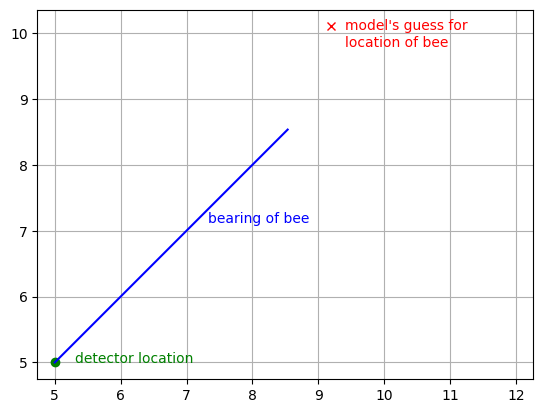

In [4]:
p = np.array([9.2, 10.1])
ob = np.array([23, 5, 5, 0.707, 0.707])

plt.plot(p[0], p[1], 'xr')
plt.text(p[0]+0.2, p[1]-0.3, "model's guess for\nlocation of bee", color='red')

plt.plot(ob[1], ob[2], 'og')
plt.text(ob[1]+0.3, ob[2], 'detector location', color='green')

plt.plot([ob[1], ob[1] + 5*ob[3]], [ob[2], ob[2] + 5*ob[4]], 'b-')
plt.text(ob[1] + 3.3*ob[3], ob[2] + 3*ob[4], 'bearing of bee', color='blue')

plt.axis('equal')
plt.xlim([4, 13])
plt.grid()
plt.show()


The predicted location lies close to the measured bearing but not perfectly aligned.
This directional mismatch is what the likelihood function quantifies.
We use this likelihood later to optimise a smooth trajectory that best explains all observations.

## Modelling Observation Likelihood

To reconstruct a continuous trajectory, we need a quantitative way to judge how well a predicted bee position aligns with a detector’s directional reading. This is captured using a **negative log-likelihood (NLL)** function that measures the mismatch between:

- the predicted direction from the detector to the estimated position  
- the observed bearing reported by the detector  

### Predicted vs. Observed Direction

Given:
- a predicted bee position `p = [px, py]`
- a detector at position `d = [dx, dy]`
- an observed unit bearing vector `b = [bx, by]`

we compute the **predicted unit direction**:

u = (p − d) / ||p − d||

The goal is to evaluate how different `u` is from the observed bearing `b`.


### Negative Log-Likelihood (NLL)

The mismatch between the predicted unit direction `u` and the observed bearing `b` is quantified as:

NLL = ( ||u − b||² ) / (2 * sigma²)
where `sigma` is a noise scale controlling how strongly we penalise directional disagreement.

A perfect alignment gives a very small NLL, while large directional errors produce high values.

### Implementation

Below is the implementation of the negative log-likelihood function used throughout the project:




In [17]:
def negloglikelihood(ob, p, noise_scale):
    detector = ob[1:3]          # detector position (dx, dy)
    bearing = ob[3:5]           # observed bearing (bx, by)

    # Vector from detector to predicted position
    vector = p - detector
    unit_vector = vector / np.linalg.norm(vector)   # predicted direction

    error = unit_vector - bearing                   # directional mismatch
    nll = np.dot(error, error) / (2 * noise_scale**2)

    return nll

Behaviour of the NLL Function
When the predicted location lies on the observed bearing line,
→ u ≈ b → NLL is small (good fit).
When the prediction is slightly off the true direction,
→ u − b becomes non-zero → NLL increases smoothly.
When the predicted position points in a completely different direction,
→ u differs sharply from b → NLL becomes large (poor fit).
This likelihood forms a key component of the total objective used to estimate the full trajectory across all timestamps.





   detector positions: $$\mathbf{d} = [d_x, d_y]$$

 Observed bearing (unit vector):
   $$\mathbf{b} = [b_x, b_y]$$

 Vector to predicted position:
   $$\mathbf{v} = \mathbf{p} - \mathbf{d} = [p_x - d_x, p_y - d_y]$$

 Unit vector pointing to predicted position:
   $$\mathbf{u} = \frac{\mathbf{v}}{\|\mathbf{v}\|}$$
   Where:
   
   $$\|\mathbf{v}\| = \sqrt{(p_x - d_x)^2 + (p_y - d_y)^2}$$

 Vector Normalization:
 $$\mathbf{u_x} = \left[\frac{p_x - d_x}{\|\mathbf{v}\|}\right],   \mathbf {u_y} = \left[\frac{p_y - d_y}{\|\mathbf{v}\|}\right]$$

   $$\mathbf{u} = \left[\frac{p_x - d_x}{\|\mathbf{v}\|}, \frac{p_y - d_y}{\|\mathbf{v}\|}\right]$$

 Error vector:
   $$\mathbf{e} = \mathbf{u} - \mathbf{b} = \left[\frac{p_x - d_x}{\|\mathbf{v}\|} - b_x, \frac{p_y - d_y}{\|\mathbf{v}\|} - b_y\right]$$

 Squared length of the error vector:
   $$l^2 = \mathbf{e_1^2} + \mathbf{e_2^2} = \left(\frac{p_x - d_x}{\|\mathbf{v}\|} - b_x\right)^2 + \left(\frac{p_y - d_y}{\|\mathbf{v}\|} - b_y\right)^2$$

 Negative log-likelihood:
   $$-\log(p(l)) = \frac{l^2}{2\sigma^2}$$


## Modelling the Bee’s Trajectory with Gaussian Basis Functions

To reconstruct a smooth 2D trajectory over time, the bee’s x(t) and y(t) coordinates are modelled using a **Gaussian basis function regression model**.  
Instead of predicting each point independently, the trajectory is expressed as a weighted sum of smooth time-dependent basis functions.

### Gaussian Basis Representation

For a set of basis centres c₁, c₂, ..., c_B, the position at time t is computed as:

f(t) = Σ [ w_b * exp( − (t − c_b)² / (2 * alpha²) ) ]

where:
- `w_b` are the learnable weights
- `c_b` are fixed basis centres (e.g., −3, 1, 5, …, 29, 33 seconds)
- `alpha` controls the width of each Gaussian basis (e.g., 3 seconds)

This representation produces a **smooth, continuous** path and allows the trajectory to be learned using only a limited number of parameters.

### Independent Modelling of x(t) and y(t)

The bee’s horizontal and vertical motion are modelled separately:
- One set of weights for x(t)
- A second set for y(t)

This keeps the model simple while still allowing flexible trajectories.

### Implementation

The following helper function generates predictions for a given weight vector `w`, set of time points `T`, and Gaussian width:


In [7]:
def getpred(T, w, width):
    basiscentres = np.linspace(-3, 33, len(w))
    pred = np.zeros_like(T)

    for b in range(len(w)):
        pred += w[b] * np.exp(-(T - basiscentres[b])**2 / (2 * width**2))

    return pred

## Total Objective Function: Likelihood + Regularisation

To estimate the full trajectory, the goal is to find the weight vectors that best explain all recorded observations while maintaining a smooth, well-behaved path.  
This is achieved through a **regularised negative log-likelihood objective**.

### Components of the Objective

For each predicted time point, the model generates a position using the Gaussian basis regression described earlier.  
For each detector observation, the negative log-likelihood (NLL) quantifies how well the predicted position aligns with the observed bearing.

The total cost combines:

1. **Likelihood term**  
   Measures directional agreement across all observations.

2. **L2 regularisation (weight decay)**  
   Penalises overly large weights to avoid unrealistic oscillations in the reconstructed path.

### Objective Function

Let:
- `w` be the weight vector for either x(t) or y(t)
- `obs[i]` be the i-th observation
- `p[i]` be the predicted position at that time  
- `sigma` be the noise scale  
- `lambda` be the regularisation strength

The total objective is:

J(w) = Σ [ NLL(obs_i | p_i, sigma²) ] + lambda * Σ (w_b²)

Where:
- The first summation runs over all observations
- The second applies L2 regularisation to all weights

This formulation encourages trajectories that simultaneously:
- Fit the detector bearings well  
- Remain smooth and physically plausible  

### Implementation

The following function computes the total objective for a given weight vector:




In [18]:
def totalnegloglikelihood(w, obs, reg, noise_scale, width=3):
    # Split combined weight vector into x and y parts
    B = len(w) // 2
    w_x = w[:B]
    w_y = w[B:]

    times = obs[:, 0]

    # Predicted x(t) and y(t) at observation times
    predx = getpred(times, w_x, width)
    predy = getpred(times, w_y, width)

    # Sum of negative log-likelihoods over all observations
    likelihood_term = 0.0
    for i in range(len(obs)):
        p = np.array([predx[i], predy[i]])   # 2D predicted position
        likelihood_term += negloglikelihood(obs[i], p, noise_scale)

    # L2 regularisation on both weight sets
    regularisation_term = reg * (np.sum(w_x**2) + np.sum(w_y**2))

    return likelihood_term + regularisation_term


In [19]:
def getpred(T, w, width):
    basiscentres = np.linspace(-3, 33, len(w))
    pred = np.zeros_like(T, dtype=float)
    for b in range(len(w)):
        pred += w[b] * np.exp(-(T - basiscentres[b])**2 / (2 * width**2))
    return pred


In [20]:
import numpy as np
from scipy.optimize import minimize

dataset = np.load('bee_flightpaths.npy', allow_pickle=True)

bee_index = 1
obs = dataset[bee_index]['observations']
truepath = dataset[bee_index]['truepath']

B = 20  # number of basis functions for each of x and y

# Initial weights: first B for x, next B for y
w0 = np.random.normal(0, 1, size=2 * B)

result = minimize(
    fun=lambda w: totalnegloglikelihood(w, obs, reg=0.001, noise_scale=0.1),
    x0=w0,
    method='L-BFGS-B'
)

w_opt = result.x
print("Optimised weight vector shape:", w_opt.shape)


Optimised weight vector shape: (40,)


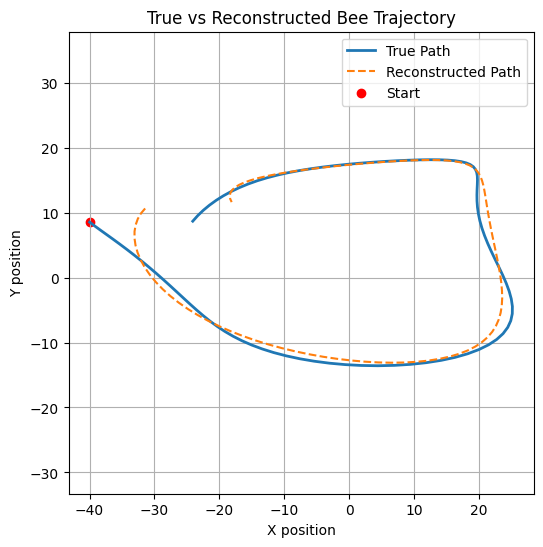

In [21]:
# Unpack weights
w_x_opt = w_opt[:B]
w_y_opt = w_opt[B:]

# Use full time grid from the ground-truth path
T = truepath[:, 0]

x_pred = getpred(T, w_x_opt, width=3)
y_pred = getpred(T, w_y_opt, width=3)

# Plot
plt.figure(figsize=(6, 6))

plt.plot(truepath[:, 1], truepath[:, 2],
         label='True Path', linewidth=2)
plt.plot(x_pred, y_pred,
         label='Reconstructed Path', linestyle='--')

plt.scatter(truepath[0, 1], truepath[0, 2],
            color='red', label='Start')

plt.xlabel('X position')
plt.ylabel('Y position')
plt.title('True vs Reconstructed Bee Trajectory')
plt.legend()
plt.axis('equal')
plt.grid()
plt.show()


Now you should see a proper 2D reconstructed path that actually follows the true bee trajectory, not just some diagonal.